# Table of Contents

- [Imports](#Imports)
- [Plan](#Plan)
- [Visualizing the Signal Mixing Problem](#Visualizing)
- [Building the Lapis Cut](#Lapis)
- [Kolmogorov-Smirnov Tests](#KS)
    - [Signal Mixing](#Mixing)
    - [Sum of Signals](#Sum)
    - [Emotions](#Emotion)
- [Mann-Whitney Tests](#MW)
    - [Type Distribution](#Type)
    - [Lead Energetic](#Lead)
    - [Quadra](#Quadra)
    - [Development](#Development)
    - [Candid Signals](#Candid)
    - [Measured Signals](#Measured)
    - [Grounded Signals](#Grounded)
    - [Suspended Signals](#Suspended)
    - [Unguarded Signals: An Unusual Change](#Unguarded)
- [Saving the Data](#Saving)

## Imports <a id="Imports"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from distfit import distfit
from scipy.stats import ks_2samp, mannwhitneyu

## Plan <a id="Plan"></a>

I have three "cuts" of the data that I want to perform machine learning on:

- all the usable data (i.e. excluding entries that don't have reports)

- the "Auburn" cut, which should remove Vultology reports from authors that have 20 or fewer reports (since they are less experienced)

- the "Lapis" cut, layered over the Auburn cut, which should take into account this analysis:
"I'm seeing something rather suspicious in the data. If I calculate P-axis coordinates with the formula (Suspended - Grounded )/(Suspended + Grounded ), which ranges from -1 (completely Grounded) to +1 (completely Suspended), then there are 90 samples with -1, i.e., Grounded with zero signal mixing.  However, there are only 8 samples in the (-1, -0.9] interval.  In the (-0.9, 0.8] interval there are 40 samples. IMO that strongly suggests that many of those Grounded samples with zero P-axis signal mixing have neglected Suspended signals. The other end of the spectrum also looks suspicious, though it's less extreme. 
There are 36 samples with P-axis coordinates of 1 (Suspended with zero signal mixing), only 3 samples in the [0.9, 1) interval, but 26 samples in the [0.8, 0.9) interval. As for J-axis coordinates, (Measured - Candid)/(Measured + Candid), there are 55 samples with coordinates of 1 (Measured with zero signal mixing), 23 samples in the [0.9, 1) interval, and 35 in the [0.8, 0.9) interval.  There's still an odd dip, but it's a lot less suspicious. At the other end, there are 23 samples with -1 (Candid with zero signal mixing), 12 samples in the (-1, -0.9] interval and 18 samples in the (-0.9, -0.8] interval. It might be worth repeating the statistical analysis reported earlier in this channel just on samples in the (-0.9, 0.9) intervals."

We will see if these different versions of the data give different statistical results or different results in machine learning algorithms.

For now the focus is on the Lapis cut of the data. There are a lot of things to statistically investigate in each of these versions of the data, and I don't want to waste time and energy. Thus, I'm going to statistically compare all of the usable data to the Lapis cut to see if there is a statistically significant difference in the distribution of each column. I'll only bother to investigate a column if there is a statistically significant difference in the distribution as a result of applying the cut.

First we need to build the Lapis Cut so we can make the comparisons, and to do that we'll need to calculate the scores Lapis mentioned and remove samples with no signal mixing at all (actually we can probably do that in another way with numbers we've already calculated). It might also be useful to visualize what Lapis is talking about in the Full Data by using some charts

## Visualizing the Signal Mixing Problem <a id="Visualizing"></a>

In [2]:
all_df = pd.read_csv('../Data/posts_2024-12-29_CleanData.csv', index_col=0)
all_df.reset_index(drop=True, inplace=True)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 87 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sample Name                    672 non-null    object 
 1   Vultologist                    672 non-null    object 
 2   Type                           672 non-null    object 
 3   Development                    672 non-null    object 
 4   Emotions                       672 non-null    object 
 5   Fallen Affect                  672 non-null    float64
 6   Sex                            672 non-null    object 
 7   Age Range                      672 non-null    object 
 8   Geography                      672 non-null    object 
 9   Ethnicity                      672 non-null    object 
 10  R1 Rigid Posture               672 non-null    float64
 11  R2 Face Centric                672 non-null    float64
 12  R3 Punctuated Motions          672 non-null    flo

We need to sum together the quadra signal scores for each of the 4 quadra signal groups

In [3]:
all_df['Candid'] = all_df.iloc[:, 40:49].sum(axis=1)
all_df['Measured'] = all_df.iloc[:, 49:58].sum(axis=1)
all_df['Grounded'] = all_df.iloc[:, 58:66].sum(axis=1)
all_df['Suspended'] = all_df.iloc[:, 66:74].sum(axis=1)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 91 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sample Name                    672 non-null    object 
 1   Vultologist                    672 non-null    object 
 2   Type                           672 non-null    object 
 3   Development                    672 non-null    object 
 4   Emotions                       672 non-null    object 
 5   Fallen Affect                  672 non-null    float64
 6   Sex                            672 non-null    object 
 7   Age Range                      672 non-null    object 
 8   Geography                      672 non-null    object 
 9   Ethnicity                      672 non-null    object 
 10  R1 Rigid Posture               672 non-null    float64
 11  R2 Face Centric                672 non-null    float64
 12  R3 Punctuated Motions          672 non-null    flo

Here are the metrics that Lapis used in his analysis:

In [4]:
all_df['J_Mixing_2Sided'] = (all_df['Measured'] - all_df['Candid'])/(all_df['Measured'] + all_df['Candid'])
all_df['P_Mixing_2Sided'] = (all_df['Suspended'] - all_df['Grounded'])/(all_df['Suspended'] + all_df['Grounded'])
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 93 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sample Name                    672 non-null    object 
 1   Vultologist                    672 non-null    object 
 2   Type                           672 non-null    object 
 3   Development                    672 non-null    object 
 4   Emotions                       672 non-null    object 
 5   Fallen Affect                  672 non-null    float64
 6   Sex                            672 non-null    object 
 7   Age Range                      672 non-null    object 
 8   Geography                      672 non-null    object 
 9   Ethnicity                      672 non-null    object 
 10  R1 Rigid Posture               672 non-null    float64
 11  R2 Face Centric                672 non-null    float64
 12  R3 Punctuated Motions          672 non-null    flo

Now we can visualize them:

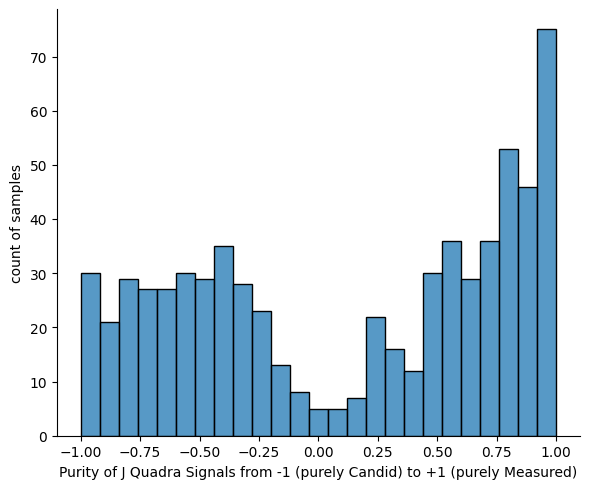

In [5]:
sns.displot(all_df[['J_Mixing_2Sided']], x='J_Mixing_2Sided', aspect=1.2, bins=25)
plt.xlabel("Purity of J Quadra Signals from -1 (purely Candid) to +1 (purely Measured)")
plt.ylabel("count of samples");

We can clearly see the dips Lapis was talking about, where the bar on the far left and right dips down lower in the 2nd to last bar on each side, and then it goes up again. This non-smmooth distribution could suggest a few things:
- some samples in the extreme right and left are not marking subtle and low point value examples of the opposite quadra value signals
- it's some kind of measurement artifact of how the signals are measured (since the point values of the signals themselves are in discrete jumps from 2, 4 and 7 which are technically arbitrary), this could also be relevant since there are several other dips in the diagram which might be produced from these measurement artifacts rather than people "forgetting to mark signals"

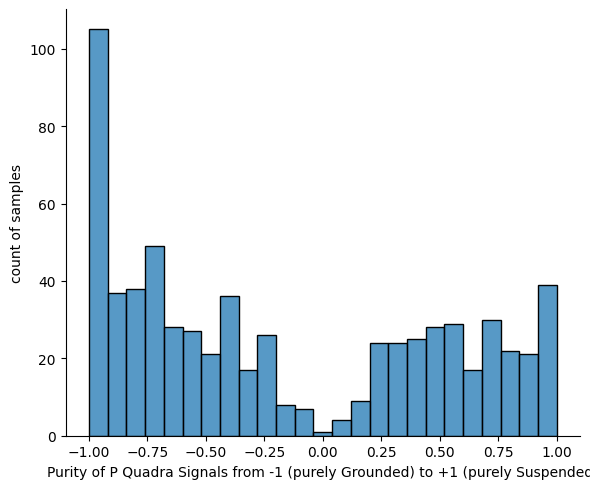

In [6]:
sns.displot(all_df[['P_Mixing_2Sided']], x='P_Mixing_2Sided', aspect=1.2, bins=25)
plt.xlabel("Purity of P Quadra Signals from -1 (purely Grounded) to +1 (purely Suspended)")
plt.ylabel("count of samples");

This jump is perhaps more suspiciously large than the one for the J axis (especially towards the grounded side, which is especially noteworthy since grounded samples are our most common by the largest margin of all quadra signals). But again there are other dips on this graph which might come from measurement artifacts

In any case, we can see the problem (and can see visually why it's worst in the case of grounded samples), which gives a more proper intuitive sense of its potential impact. Now we can test what statistical impacts it might have by building the Lapis cut and performing the same tests that we used for the Auburn Cut

## Building the Lapis Cut <a id="Lapis"></a>

We'll also start building lapis_df from the Auburn Cut so that our cuts can be a continuous series of progressively getting rid of more and more data, which means we'll need to perform the same cut of Vultologists that we did before first:

In [7]:
lapis_df = all_df[all_df['Vultologist'].isin(['Calin Copil', 'Juan E. Sandoval', 'Peter Foy', 'Sierra Schwartz', 'Ash Rose'])]
lapis_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 605 entries, 0 to 671
Data columns (total 93 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sample Name                    605 non-null    object 
 1   Vultologist                    605 non-null    object 
 2   Type                           605 non-null    object 
 3   Development                    605 non-null    object 
 4   Emotions                       605 non-null    object 
 5   Fallen Affect                  605 non-null    float64
 6   Sex                            605 non-null    object 
 7   Age Range                      605 non-null    object 
 8   Geography                      605 non-null    object 
 9   Ethnicity                      605 non-null    object 
 10  R1 Rigid Posture               605 non-null    float64
 11  R2 Face Centric                605 non-null    float64
 12  R3 Punctuated Motions          605 non-null    float64


Now we're more or less back where we were, except for the extra columns, but we'll need to use those extra columns to make the next cut of the data, using the interval (-0.9, 0.9) on the signal mixing axes for the next cut:

In [8]:
lapis_df = lapis_df[(lapis_df['J_Mixing_2Sided'] > -0.9) & (lapis_df['J_Mixing_2Sided'] < 0.9)]
lapis_df = lapis_df[(lapis_df['P_Mixing_2Sided'] > -0.9) & (lapis_df['P_Mixing_2Sided'] < 0.9)]
lapis_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, 1 to 667
Data columns (total 93 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sample Name                    373 non-null    object 
 1   Vultologist                    373 non-null    object 
 2   Type                           373 non-null    object 
 3   Development                    373 non-null    object 
 4   Emotions                       373 non-null    object 
 5   Fallen Affect                  373 non-null    float64
 6   Sex                            373 non-null    object 
 7   Age Range                      373 non-null    object 
 8   Geography                      373 non-null    object 
 9   Ethnicity                      373 non-null    object 
 10  R1 Rigid Posture               373 non-null    float64
 11  R2 Face Centric                373 non-null    float64
 12  R3 Punctuated Motions          373 non-null    float64


We just cut a total of 232 samples, which is much more than last time and since we already have some intuition that the samples we removed are more statistically significant in the distributions of some signals, I think this is more likely to have a statistical impact on our test p-values (and thus on the results of other statistical tests, investigations and clustering)

Now we need to get rid of the new columns, and reset the original all_df so that we can properly compare the two versions of the data:

In [9]:
all_df = pd.read_csv('../Data/posts_2024-12-29_CleanData.csv', index_col=0)
all_df.reset_index(drop=True, inplace=True)
lapis_df = lapis_df.iloc[:, :87].copy()
lapis_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, 1 to 667
Data columns (total 87 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sample Name                    373 non-null    object 
 1   Vultologist                    373 non-null    object 
 2   Type                           373 non-null    object 
 3   Development                    373 non-null    object 
 4   Emotions                       373 non-null    object 
 5   Fallen Affect                  373 non-null    float64
 6   Sex                            373 non-null    object 
 7   Age Range                      373 non-null    object 
 8   Geography                      373 non-null    object 
 9   Ethnicity                      373 non-null    object 
 10  R1 Rigid Posture               373 non-null    float64
 11  R2 Face Centric                373 non-null    float64
 12  R3 Punctuated Motions          373 non-null    float64


## Kolmogorov-Smirnov Tests <a id="KS"></a>

The distributions we can examine with this test are the most complex relatively continuous distributions such as:
- sum of signals
- Emotion value distributions
- Signal mixing distributions

In [10]:
KS_cols = ['sum', 'Emotion_Val', 'Emotion_RawDiff', 'J_Signal_Mixing', 'P_Signal_Mixing']

KS_results = {}

for col in KS_cols:
    stat, p_value = ks_2samp(all_df[col], lapis_df[col])
    KS_results[col] = {'statistic': stat, 'p_value': p_value.round(3)}

KS_df = pd.DataFrame.from_dict(KS_results)
KS_df.transpose()

,statistic,p_value
sum,0.063074,0.280
Emotion_Val,0.057489,0.388
Emotion_RawDiff,0.047850,0.620
J_Signal_Mixing,0.214852,0.000
P_Signal_Mixing,0.235119,0.000


As would be expected, the signal mixing distributions are different without any doubt whatsoever since we specifically removed samples from them based on criteria directly related to signal mixing. The others aren't different by what is typically considered a statistically significant amount (which is good since it means that the samples we removed likely weren't systematically flawed in many ways, if any at all), but the P values are low enough for some that I'd be curious to examine the differences (such as for sum)

### Signal Mixing <a id="Mixing"></a>

In [11]:
lapis_df['J_Signal_Mixing'].describe()

count    373.000000
mean       0.454737
std        0.211419
min        0.105263
25%        0.266667
50%        0.434783
75%        0.622222
max        0.984127
Name: J_Signal_Mixing, dtype: float64

The central tendency is ofc quite a bit higher here since we removed samples who have very low signal mixing

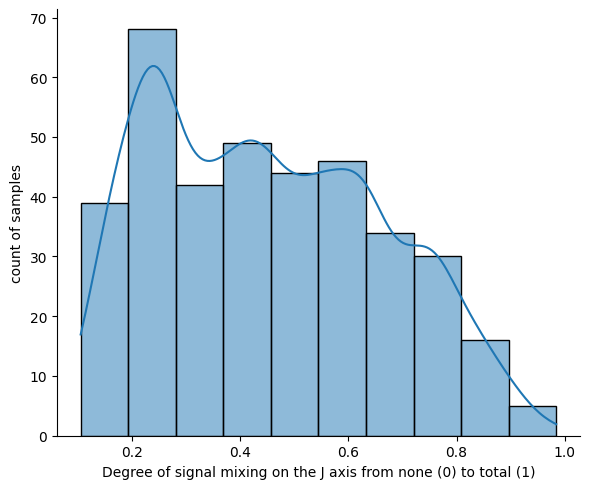

In [12]:
sns.displot(lapis_df[['J_Signal_Mixing']], x='J_Signal_Mixing', kde=True, kde_kws={'bw_adjust': 0.6}, aspect=1.2)
plt.xlabel("Degree of signal mixing on the J axis from none (0) to total (1)")
plt.ylabel("count of samples");

What's interesting here is that there are still pretty noticeable spikes in the data, even when we remove the extremes, so it seems unlikely that the spikes are just caused extremes; it may be more likely that it's a measurement artifact but I don't claim to know the exact cause

In [13]:
lapis_df['J_Signal_Mixing'].skew(), lapis_df['J_Signal_Mixing'].kurtosis()

(0.29547068971052937, -0.9322226772120925)

The skew and kurtosis oddly changed very little, which might also suggest that the values we removed weren't particularly "special" with regard to the shape of the distribution

In [14]:
dfit = distfit(n_boots=100)
results = dfit.fit_transform(lapis_df['J_Signal_Mixing'])
dfit.summary[['name', 'score', 'bootstrap_score', 'bootstrap_pass']]

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.12 sec] [RSS: 1.79135] [loc=0.455 scale=0.211]
[distfit] >INFO> [expon     ] [0.12 sec] [RSS: 3.08783] [loc=0.105 scale=0.349]
[distfit] >INFO> [pareto    ] [0.20 sec] [RSS: 3.08783] [loc=-67108863.895 scale=67108864.000]
[distfit] >INFO> [dweibull  ] [0.99 sec] [RSS: 1.66435] [loc=0.466 scale=0.200]
[distfit] >INFO> [t         ] [8.05 sec] [RSS: 1.79134] [loc=0.455 scale=0.211]
[distfit] >INFO> [genextreme] [4.39 sec] [RSS: 1.58484] [loc=0.369 scale=0.191]
[distfit] >INFO> [gamma     ] [1.08 sec] [RSS: 1.24333] [loc=0.040 scale=0.125]
[distfit] >INFO> [lognorm   ] [0.82 sec] [RSS: 1.52826] [loc=-0.310 scale=0.736]
[distfit] >INFO> [beta      ] [2.11 sec] [RSS: 0.426922] [loc=0.103 scale=0.895]
[distfit] >INFO> [uniform   ] [0.11 sec] [RSS: 2.5926] [loc=0.105 scale=0.879]
[distfit] >INFO> [loggamma  ] [3.11 sec] [RSS: 1.77659] [loc=-38.036 scale=5.818]
[distfit] >INFO> [norm      ] [21.1 sec] [RSS: 1.79135

,name,score,bootstrap_score,bootstrap_pass
0,beta,0.426922,0.14,True
1,dweibull,1.664354,0.01,False
2,gamma,1.243328,0.0,False
3,lognorm,1.528259,0.0,False
4,genextreme,1.584842,0.0,False
5,loggamma,1.776588,0.0,False
6,t,1.791344,0.0,False
7,norm,1.791349,0.0,False
8,uniform,2.592602,0.0,False
9,pareto,3.087826,0.0,False


[distfit] >INFO> Ploting Summary.
[distfit] >INFO> Bootstrap results are included..


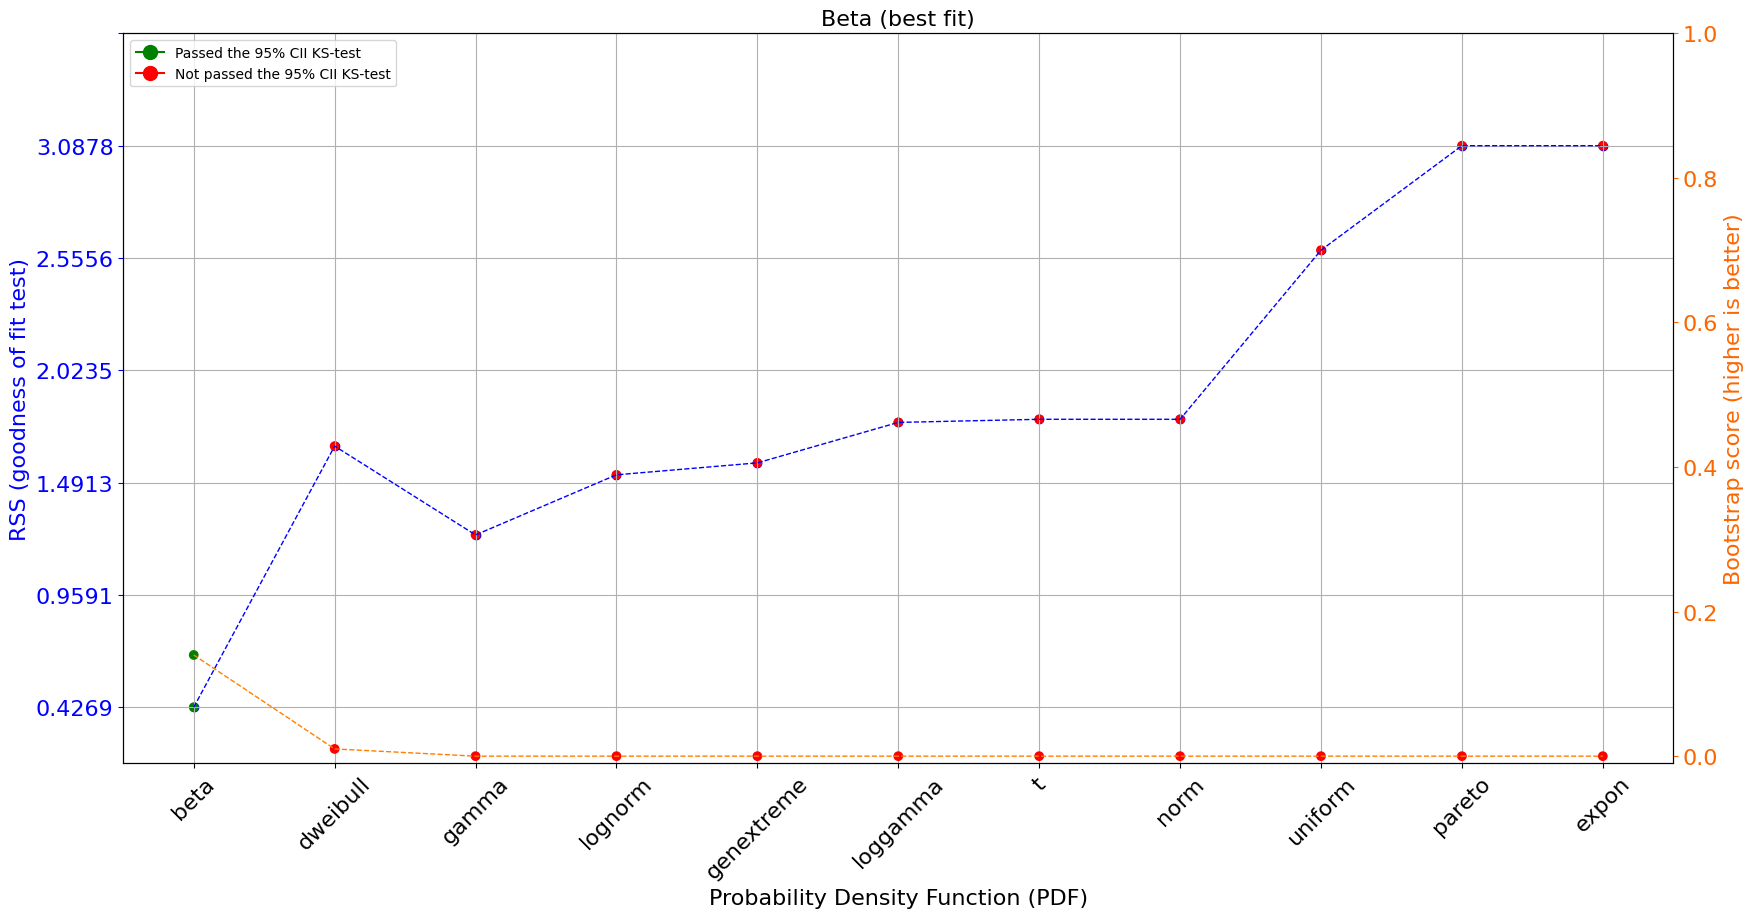

In [15]:
dfit.plot_summary();

Here we do get a pretty clear victory for the Beta distribution, which makes sense since the values are expected to fall within a certain range in spite of their uncertainty (something Beta is often used for). The bootstrap score doesn't seem very high though

In [16]:
dfit = distfit(n_boots=100, distr='full')
results = dfit.fit_transform(lapis_df['J_Signal_Mixing'])
dfit.summary[['name', 'score', 'bootstrap_score', 'bootstrap_pass']]

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [alpha          ] [2.82 sec] [RSS: 1.62096] [loc=-1.552 scale=19.161]
[distfit] >INFO> [anglit         ] [0.45 sec] [RSS: 1.44068] [loc=0.496 scale=0.628]
[distfit] >INFO> [arcsine        ] [1.99 sec] [RSS: 6.09495] [loc=0.020 scale=0.964]
[distfit] >INFO> [beta           ] [2.07 sec] [RSS: 0.426922] [loc=0.103 scale=0.895]
[distfit] >INFO> [betaprime      ] [5.53 sec] [RSS: 1.5593] [loc=-0.173 scale=32.081]
[distfit] >INFO> [bradford       ] [2.46 sec] [RSS: 1.43722] [loc=0.105 scale=0.879]
[distfit] >INFO> [burr           ] [12.0 sec] [RSS: 0.897401] [loc=0.105 scale=0.764]
[distfit] >INFO> [cauchy         ] [0.36 sec] [RSS: 3.40703] [loc=0.427 scale=0.150]
[distfit] >INFO> [chi            ] [1.92 sec] [RSS: 0.79144] [loc=0.099 scale=0.343]
[distfit] >INFO> [chi2           ] [2.00 sec] [RSS: 1.24332] [loc=0.040 scale=0.062]
[distfit] >INFO> [cosine         ] [0.50 sec] [RSS: 1.5045] [loc=0.469 scale=0.179]
[distfit] >IN

,name,score,bootstrap_score,bootstrap_pass
0,rdist,1.382334,0.7,True
1,halfgennorm,0.525004,0.62,True
2,genexpon,0.889812,0.39,True
3,foldnorm,0.725789,0.22,True
4,burr,0.897401,0.21,True
...,...,...,...,...
75,reciprocal,4.147712,0.0,False
76,levy,4.916308,0.0,False
77,arcsine,6.094953,0.0,False
78,vonmises_line,15.539235,0.0,False


[distfit] >INFO> Ploting Summary.
[distfit] >INFO> Bootstrap results are included..


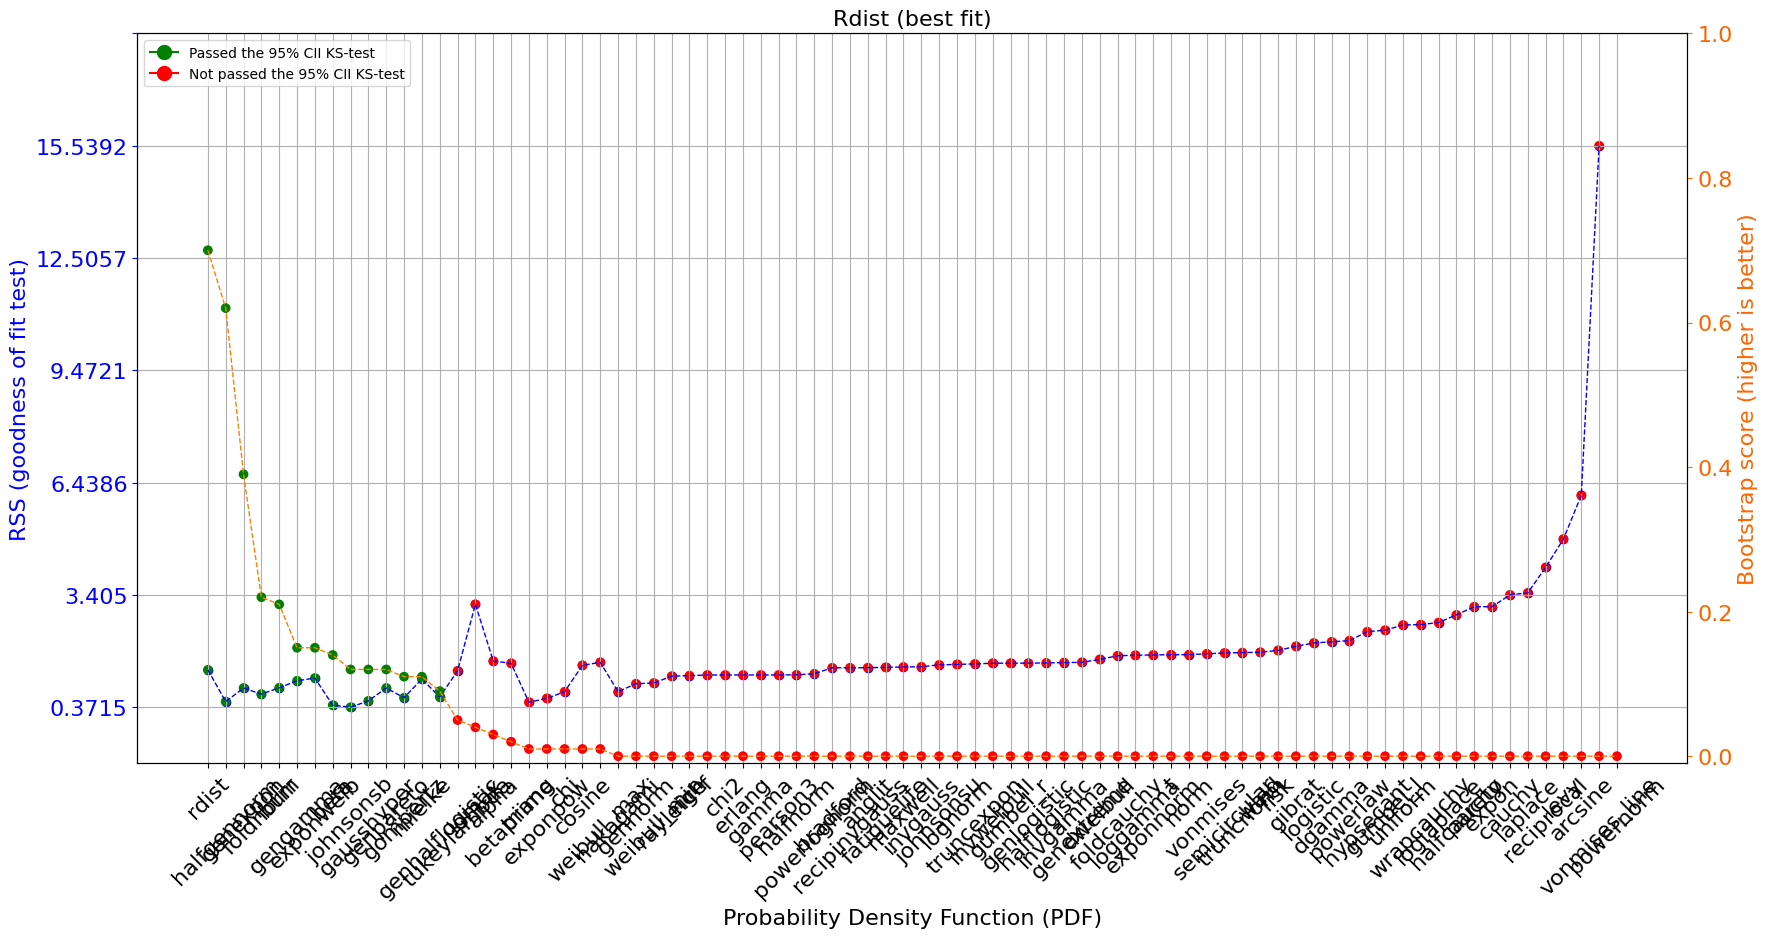

In [17]:
dfit.plot_summary();

[distfit] >INFO> Create PDF plot for the parametric method.
[distfit] >INFO> Estimated distribution: Rdist(loc:0.484117, scale:0.511366)
[distfit] >INFO> Create CDF plot for the parametric method.
[distfit] >INFO> Ploting CDF


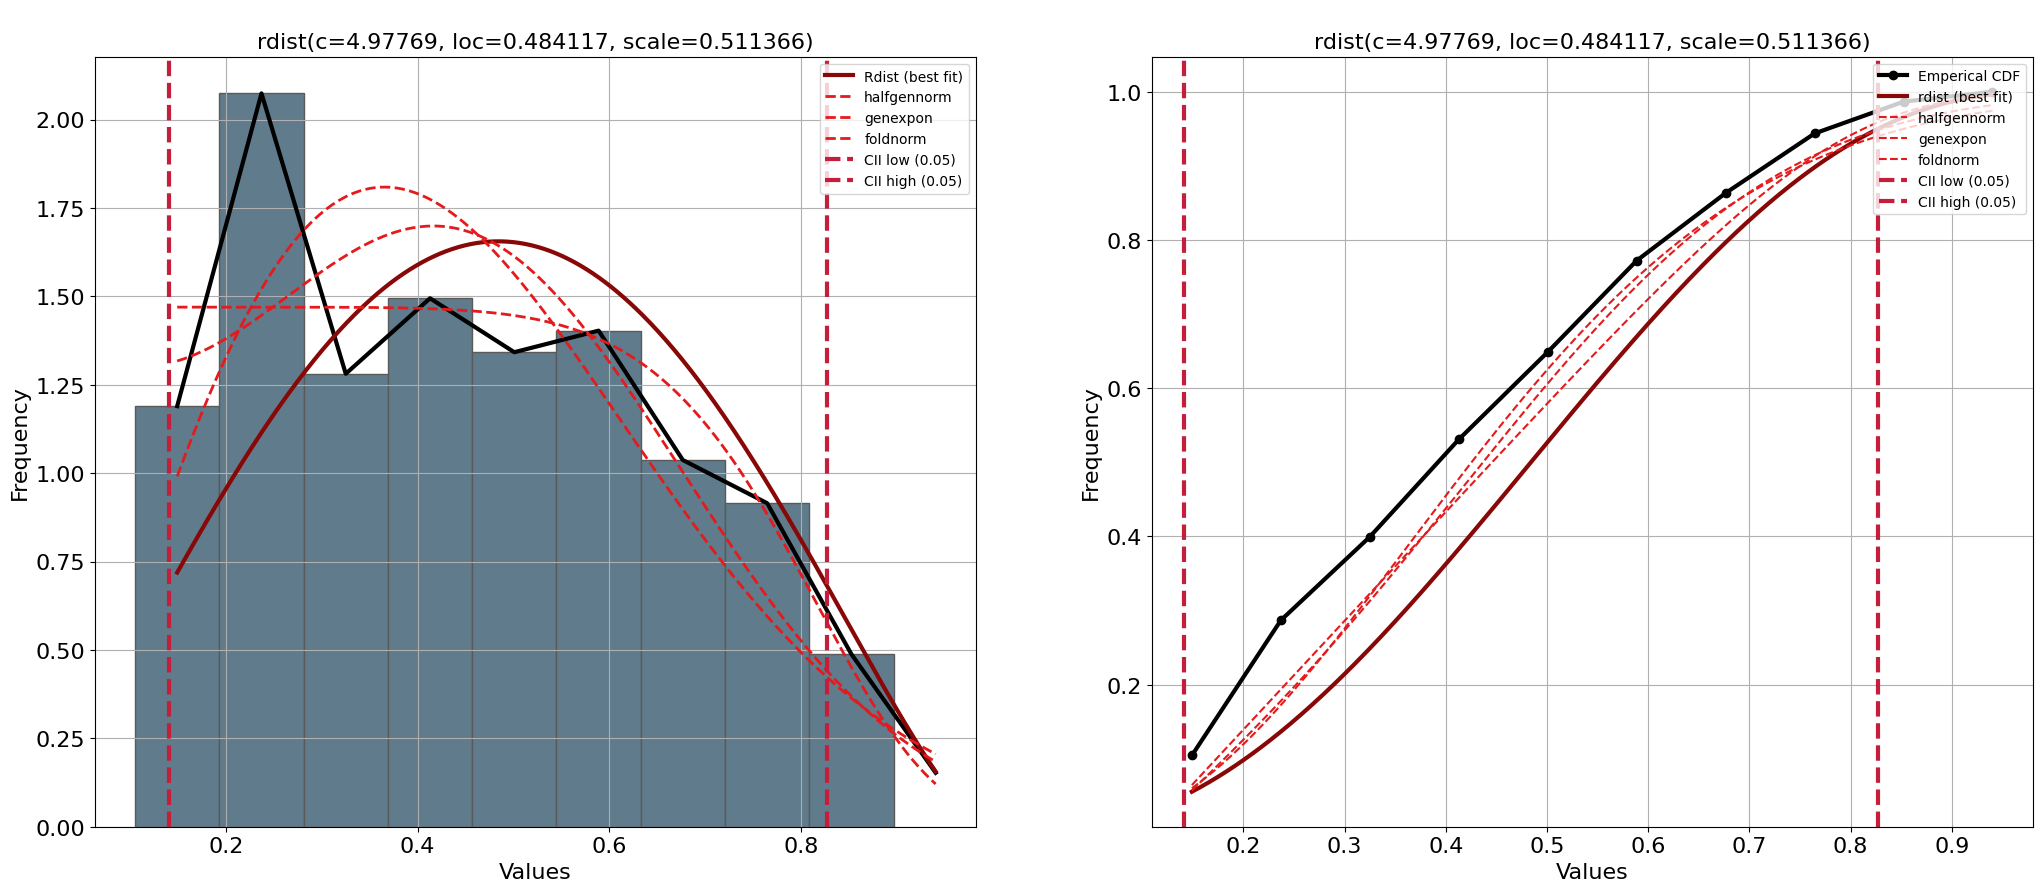

In [34]:
# Create subplot
fig, ax = plt.subplots(1,2, figsize=(25, 10))
# Plot PDF with histogram
dfit.plot(chart='PDF', n_top=3, ax=ax[0])
# Plot the CDF
dfit.plot(chart='CDF', n_top=3, ax=ax[1]);

The Rdist doesn't seem to fit very well, but halfgennorm and foldnorm (as other variants of partial normal distributions) fit well, which goes along with truncnorm fitting well for the full data on this J Signal Mixing feature (I believe the genexpon is the one with the highest bump since the halfgennorm distribution is not capable of increasing from left to right, and genexpon doesn't fit as well which makes sense since we aren't focused on extreme values)

In [35]:
lapis_df['P_Signal_Mixing'].describe()

count    373.000000
mean       0.451394
std        0.216339
min        0.105263
25%        0.275862
50%        0.425532
75%        0.612245
max        0.967742
Name: P_Signal_Mixing, dtype: float64

Same story as with J signal mixing

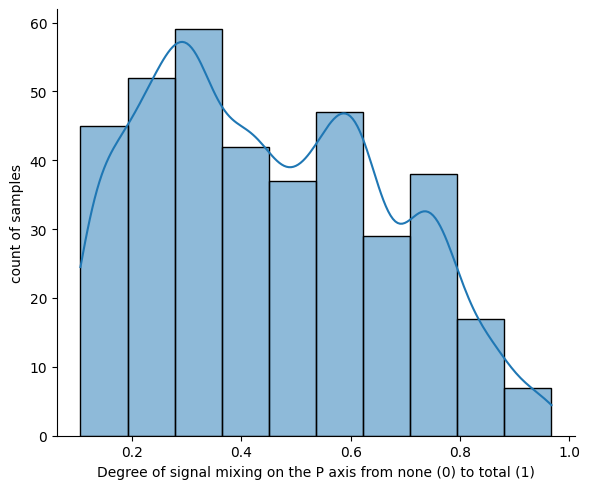

In [36]:
sns.displot(lapis_df[['P_Signal_Mixing']], x='P_Signal_Mixing', kde=True, kde_kws={'bw_adjust': 0.6}, aspect=1.2)
plt.xlabel("Degree of signal mixing on the P axis from none (0) to total (1)")
plt.ylabel("count of samples");

There are again multiple spikes in the data which makes me suspicious of measurement artifacts

In [37]:
lapis_df['P_Signal_Mixing'].skew(), lapis_df['P_Signal_Mixing'].kurtosis()

(0.29551857436750856, -0.9043390973159404)

Again not a huge difference here

In [38]:
dfit = distfit(n_boots=100)
results = dfit.fit_transform(lapis_df['P_Signal_Mixing'])
dfit.summary[['name', 'score', 'bootstrap_score', 'bootstrap_pass']]

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.17 sec] [RSS: 1.84655] [loc=0.451 scale=0.216]
[distfit] >INFO> [expon     ] [0.11 sec] [RSS: 2.81268] [loc=0.105 scale=0.346]
[distfit] >INFO> [pareto    ] [0.21 sec] [RSS: 2.81268] [loc=-16777215.895 scale=16777216.000]
[distfit] >INFO> [dweibull  ] [1.02 sec] [RSS: 1.52208] [loc=0.473 scale=0.207]
[distfit] >INFO> [t         ] [8.43 sec] [RSS: 1.84656] [loc=0.451 scale=0.216]
[distfit] >INFO> [genextreme] [4.48 sec] [RSS: 1.53474] [loc=0.364 scale=0.196]
[distfit] >INFO> [gamma     ] [1.24 sec] [RSS: 1.13797] [loc=0.025 scale=0.128]
[distfit] >INFO> [lognorm   ] [1.64 sec] [RSS: 1.42793] [loc=-0.369 scale=0.792]
[distfit] >INFO> [beta      ] [4.23 sec] [RSS: 0.401587] [loc=0.105 scale=0.873]
[distfit] >INFO> [uniform   ] [0.12 sec] [RSS: 2.18573] [loc=0.105 scale=0.862]
[distfit] >INFO> [loggamma  ] [3.17 sec] [RSS: 1.77627] [loc=-47.024 scale=6.886]
[distfit] >INFO> [norm      ] [24.8 sec] [RSS: 1.8465

,name,score,bootstrap_score,bootstrap_pass
0,beta,0.401587,0.53,True
1,dweibull,1.522076,0.01,False
2,gamma,1.137965,0.0,False
3,lognorm,1.427934,0.0,False
4,genextreme,1.534737,0.0,False
5,loggamma,1.776275,0.0,False
6,norm,1.846553,0.0,False
7,t,1.846562,0.0,False
8,uniform,2.185734,0.0,False
9,expon,2.812679,0.0,False


[distfit] >INFO> Ploting Summary.
[distfit] >INFO> Bootstrap results are included..


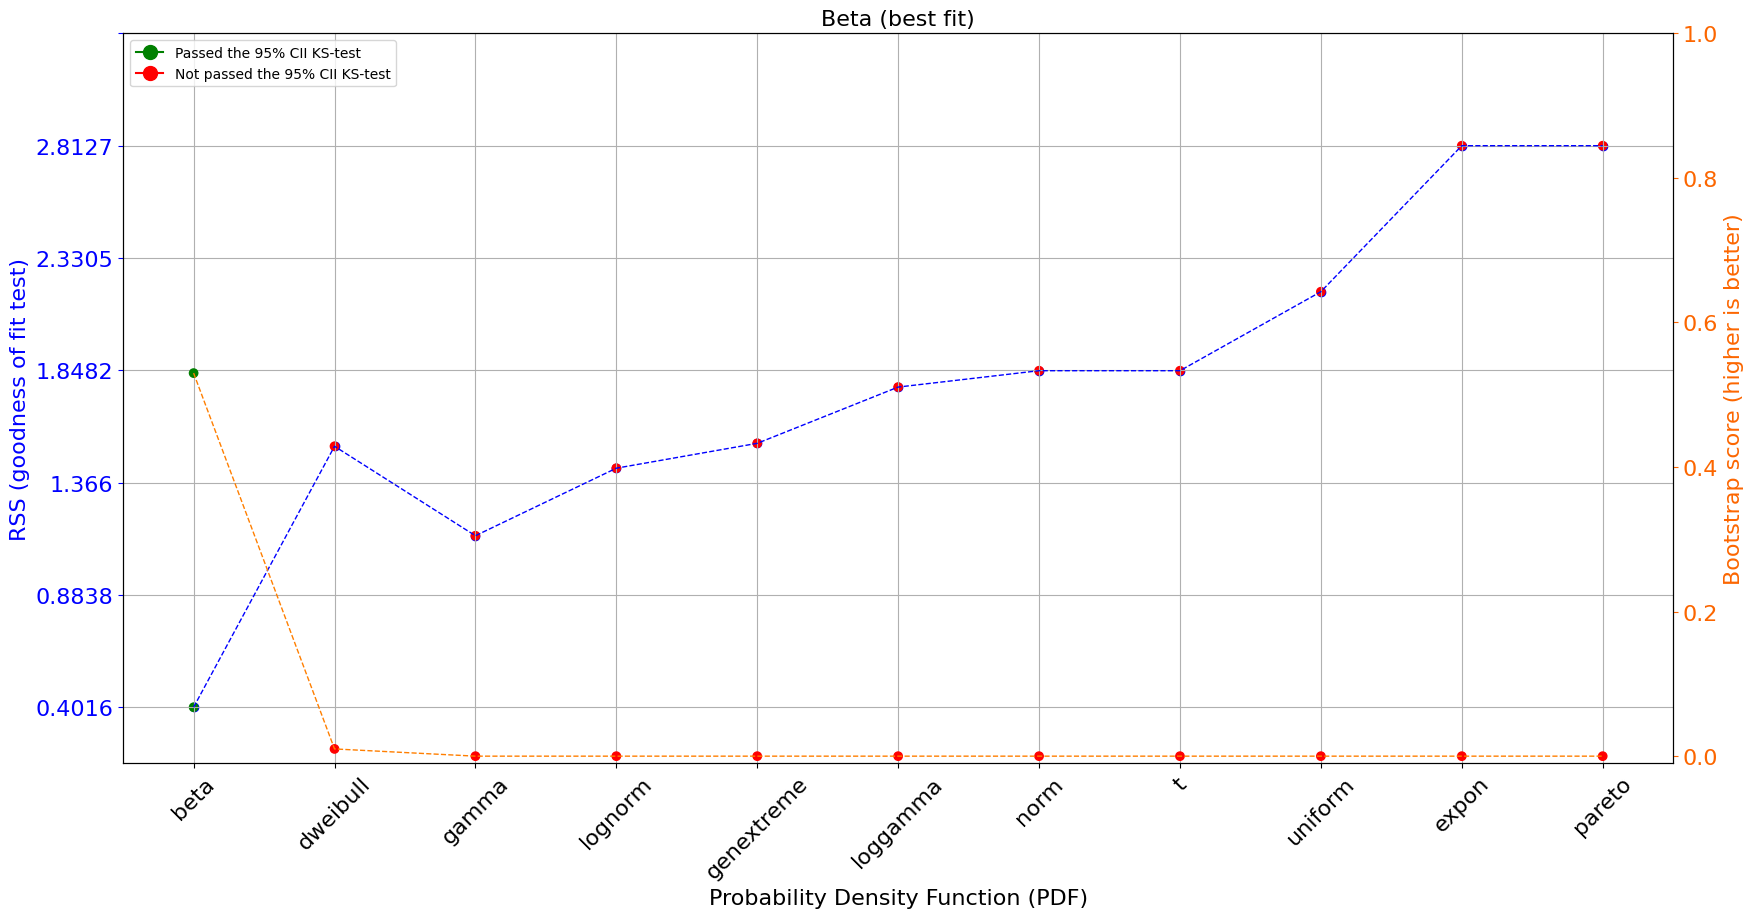

In [39]:
dfit.plot_summary();

In this case we have notably even more success with the beta distribution, and in both types of signal mixing the Beta distribution modeled it best out of the most popular distribution classes, so it really might be one of the best options in this case

In [40]:
dfit = distfit(n_boots=100, distr='full')
results = dfit.fit_transform(lapis_df['P_Signal_Mixing'])
dfit.summary[['name', 'score', 'bootstrap_score', 'bootstrap_pass']]

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [alpha          ] [2.76 sec] [RSS: 1.55162] [loc=-1.665 scale=20.832]
[distfit] >INFO> [anglit         ] [0.46 sec] [RSS: 1.38354] [loc=0.486 scale=0.626]
[distfit] >INFO> [arcsine        ] [2.12 sec] [RSS: 5.59688] [loc=0.022 scale=0.945]
[distfit] >INFO> [beta           ] [3.90 sec] [RSS: 0.401587] [loc=0.105 scale=0.873]
[distfit] >INFO> [betaprime      ] [5.61 sec] [RSS: 1.43597] [loc=-0.154 scale=3983.928]
[distfit] >INFO> [bradford       ] [2.57 sec] [RSS: 1.07699] [loc=0.105 scale=0.862]
[distfit] >INFO> [burr           ] [13.3 sec] [RSS: 0.537061] [loc=0.105 scale=0.765]
[distfit] >INFO> [cauchy         ] [0.36 sec] [RSS: 3.44157] [loc=0.419 scale=0.154]
[distfit] >INFO> [chi            ] [2.05 sec] [RSS: 0.714769] [loc=0.102 scale=0.364]
[distfit] >INFO> [chi2           ] [1.99 sec] [RSS: 1.13795] [loc=0.025 scale=0.064]
[distfit] >INFO> [cosine         ] [0.54 sec] [RSS: 1.5295] [loc=0.465 scale=0.183]
[distfit]

,name,score,bootstrap_score,bootstrap_pass
0,gausshyper,0.449509,0.54,True
1,beta,0.401587,0.45,True
2,halfgennorm,0.44364,0.39,True
3,genpareto,0.499434,0.38,True
4,mielke,0.524478,0.36,True
...,...,...,...,...
75,cauchy,3.441574,0.0,False
76,laplace,3.695244,0.0,False
77,levy,5.21848,0.0,False
78,arcsine,5.59688,0.0,False


In [42]:
dfit.summary[['name', 'score', 'bootstrap_score', 'bootstrap_pass']].head(15)

,name,score,bootstrap_score,bootstrap_pass
0,gausshyper,0.449509,0.54,True
1,beta,0.401587,0.45,True
2,halfgennorm,0.44364,0.39,True
3,genpareto,0.499434,0.38,True
4,mielke,0.524478,0.36,True
5,genhalflogistic,0.476071,0.35,True
6,exponweib,0.574722,0.31,True
7,foldnorm,0.66949,0.31,True
8,genexpon,1.061417,0.31,True
9,johnsonsb,0.354013,0.25,True


[distfit] >INFO> Ploting Summary.
[distfit] >INFO> Bootstrap results are included..


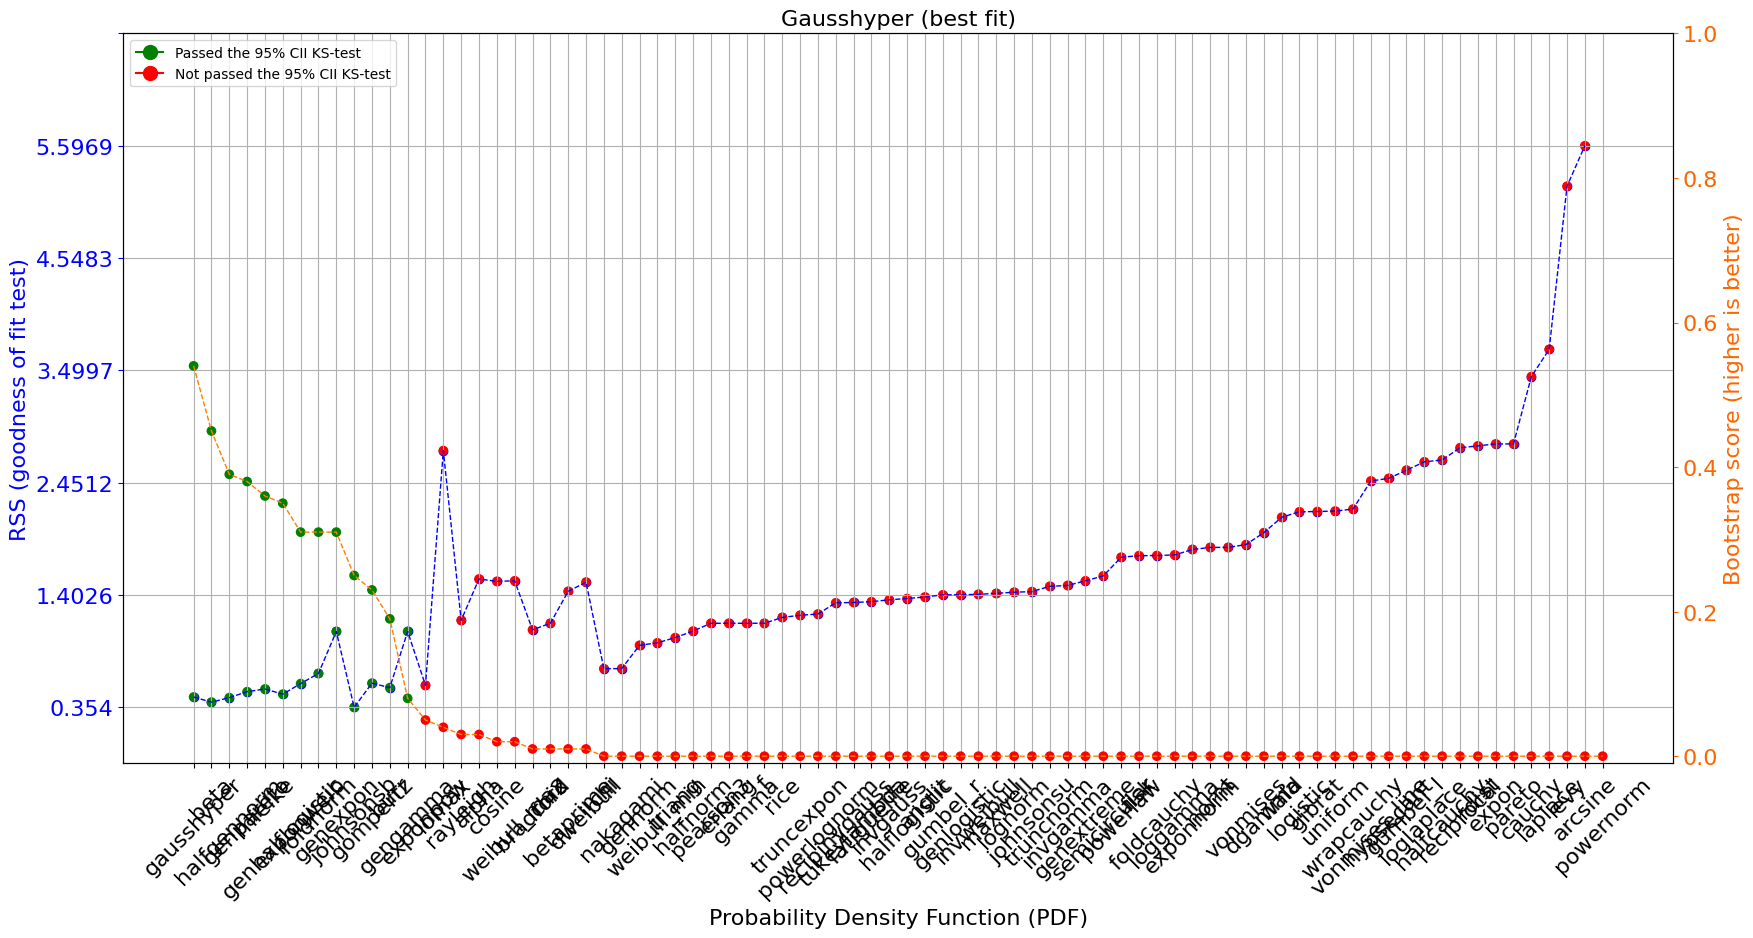

In [43]:
dfit.plot_summary();

[distfit] >INFO> Create PDF plot for the parametric method.
[distfit] >INFO> Estimated distribution: Gausshyper(loc:0.105263, scale:0.878592)
[distfit] >INFO> Create CDF plot for the parametric method.
[distfit] >INFO> Ploting CDF


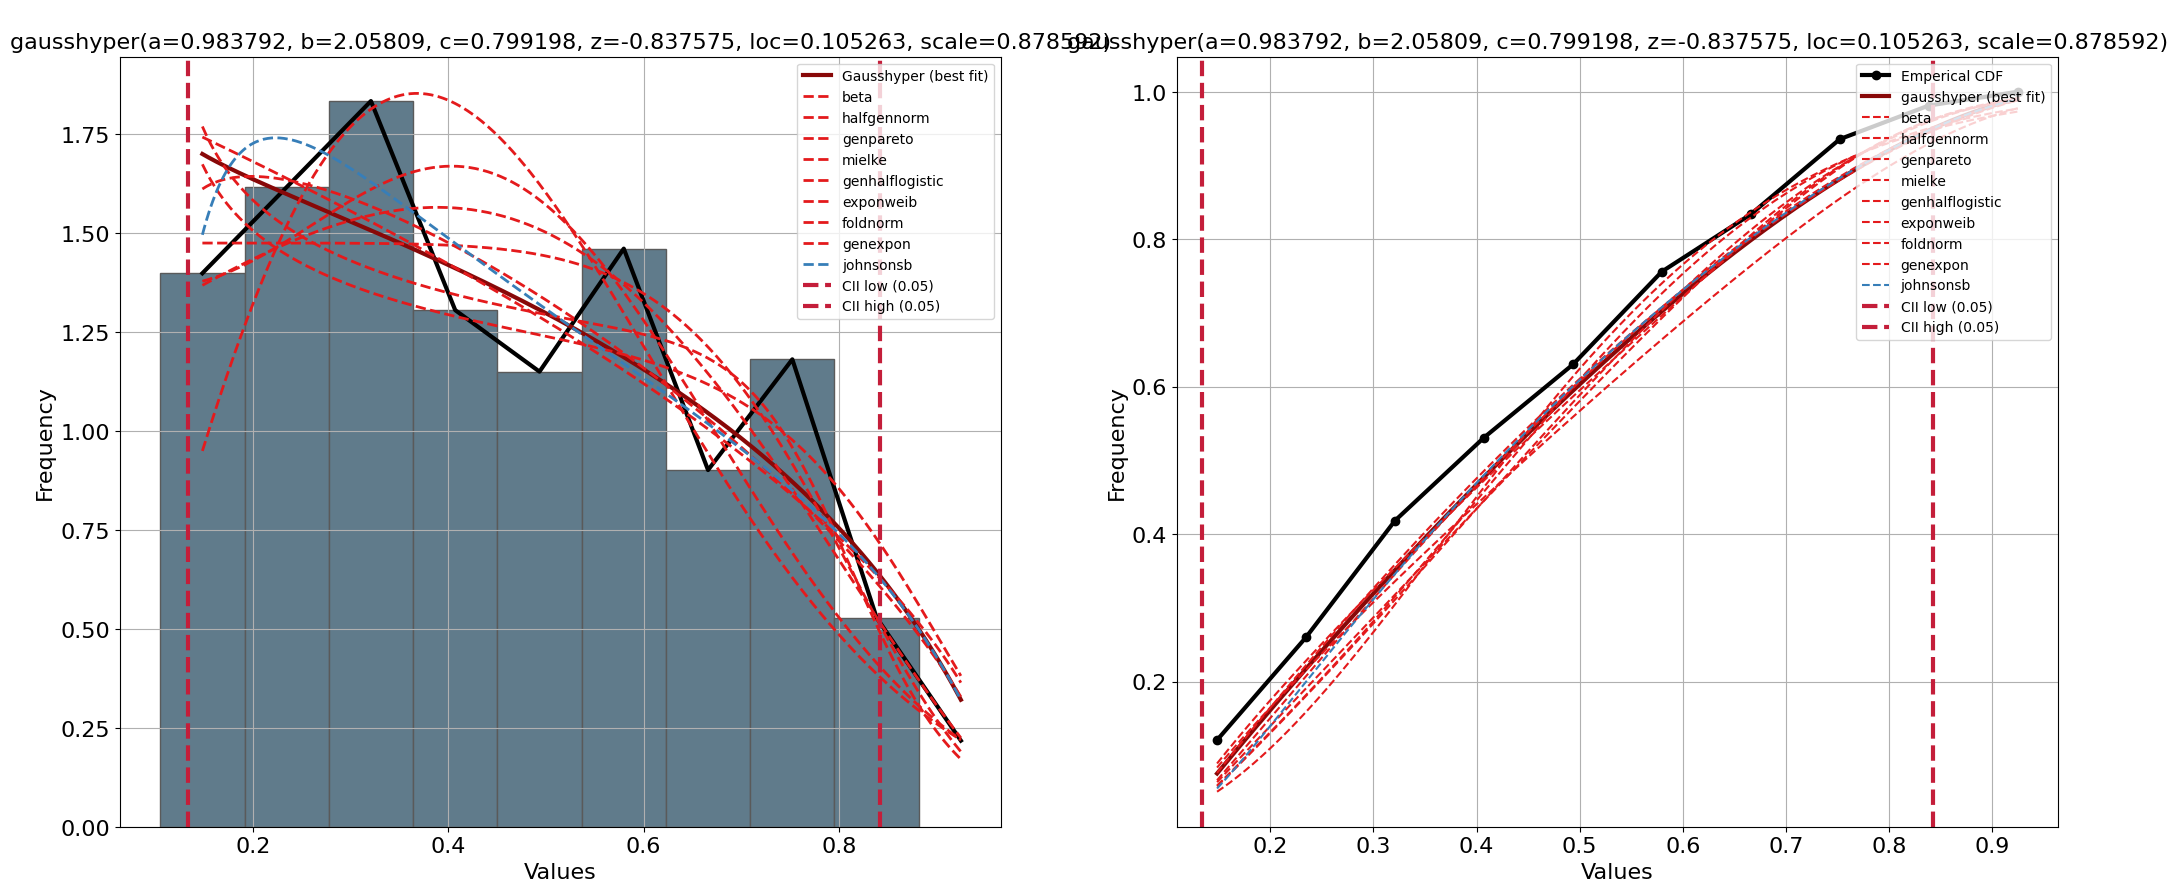

In [54]:
# Create subplot
fig, ax = plt.subplots(1,2, figsize=(25, 10))
# Plot PDF with histogram
dfit.plot(chart='PDF', n_top=9, ax=ax[0])
# Plot the CDF
dfit.plot(chart='CDF', n_top=9, ax=ax[1]);

Halfgennorm and foldnorm again do well (as with J Signal Mixing), as partial representations of a quasi-normal distribution, which could be an important sign since they did well on both processes. Even the johnsonsb distribution looks fairly reasonable and as meant to represent bounded data with skewed and non-normal distributions. Beta also does well (pretty consistently I might add).

Genexpon continues to fit relatively poorly, and the fact that it keeps being included makes me wonder whether the distfit library really scores these distributions in an ideal way for our purposes. Exponweib also doesn't fit the shape of the distribution (same with mielke) and is typically used to model failure rates changing over time which doesn't make sense here as there is no time involved. The genhalflogistic distribution also has an unreasonable bump after the largest histogram bin and doesn't fit well, and there's nothing seemingly logarithmic here.

Genpareto also doesn't fit well as it doesn't fit the fluctuations in the data well (but how many of those are artifacts is still something I'm not sure of). The gausshyper distribution, similar to Beta, is used when a continuous value is limited to some range, so it is possibly suitable here theoretically, but realistically doesn't look good (too straight of a line).

### Sum of Signals <a id="Sum"></a>

Let's start with a comparison between the full data and the lapis version:

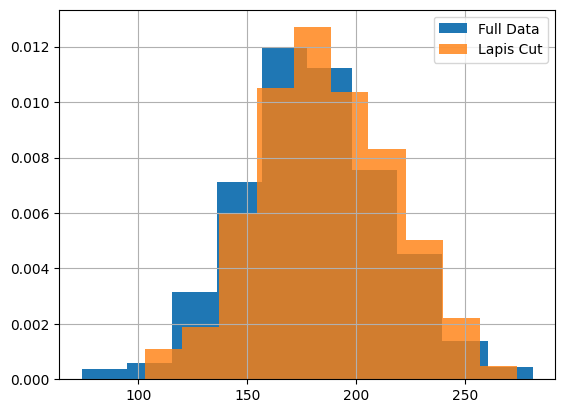

In [55]:
fig, ax = plt.subplots()

all_df['sum'].hist(label='Full Data', density=True)
lapis_df['sum'].hist(label='Lapis Cut', density=True, alpha=0.8)
ax.legend();

On the whole signals counts seem to tend to be a little higher in the Lapis Cut, which makes sense since we removed samples that didn't add any opposing quadra signals. But overall the distributions seem quite similar and I doubt it needs to be investigated in detail.

### Emotions <a id="Emotion"></a>

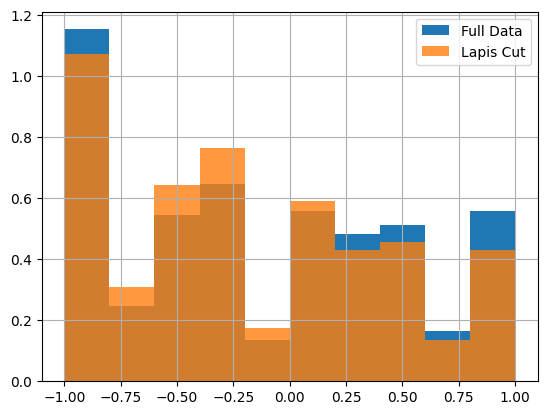

In [56]:
fig, ax = plt.subplots()

all_df['Emotion_Val'].hist(label='Full Data', density=True)
lapis_df['Emotion_Val'].hist(label='Lapis Cut', density=True, alpha=0.8)
ax.legend();

This is also quite similar overall (and has slightly lower values on average for the Lapis variant, which could make sense if we already had a pretty normally distributed set of values and took out samples that were weighted towards having more samples in other areas besides quadras, but either way it seems like a small effect)

## Mann-Whitney Tests <a id="MW"></a>

In this case we are going to look at nearly every other column, since they are all either categorical in nature or consist of signals with mainly discrete values and thus a lot of ties that make the KS test ineffective

In [57]:
MW_cols = [col for col in list(lapis_df.columns) if (col not in KS_cols) and (col not in ['Sample Name', 'Vultologist'])]

MW_results = {}

for col in MW_cols:
    if all_df[col].dtype == 'O':
        stat, p_value = mannwhitneyu(all_df[col].value_counts(), lapis_df[col].value_counts())
    else:
        stat, p_value = mannwhitneyu(all_df[col], lapis_df[col])
    MW_results[col] = {'statistic': stat, 'p_value': p_value.round(3)}

MW_df = pd.DataFrame.from_dict(MW_results)
with pd.option_context("display.max_rows", 1000):
    print(MW_df.transpose().sort_values('p_value'))

                               statistic  p_value
Type                               229.5    0.000
CA3 Four Point Pulling          112145.0    0.003
SU5 Brushstrokes Eye Toggles    113511.5    0.008
CA1 Taut Nasolabial Area        113504.0    0.008
CA4 Wobbling Lips               114393.5    0.015
MS4 Symmetrical Lips            135601.0    0.022
EU1 Responsive Nodding          115450.0    0.026
SU7 Levity Effect               115870.0    0.027
Lead Energetic                      16.0    0.029
Quadra                              16.0    0.029
CA2 Vertical Snarling Smiles    115876.5    0.032
SU2 Taut Pretarsal Area         116031.0    0.039
RR5 Meticulous Hands            116106.5    0.040
CA7 Plateau Velocity            116265.5    0.042
EU3 Bashful Body Movements      116599.5    0.043
Development                         51.0    0.051
CA6 Sassy Movements             116677.0    0.051
SU4 Concerned Scowling          117288.5    0.065
PF2 Toggling Eyes               117205.0    0.066


In this case there are really many distributions that are statistically significantly different than the full data, so we really need to look at them. Many, of course, are Quadra related since that we cut the data based on being exclusively biased towards a given quadra, but perhaps more interesting are those that aren't:

### Type Distribution <a id="Type"></a>

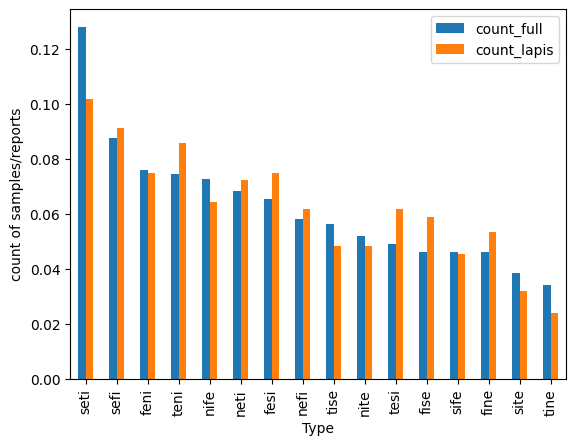

In [58]:
type_join = (all_df['Type'].value_counts()/len(all_df)).to_frame().join((lapis_df['Type'].value_counts()/len(lapis_df)).to_frame(), lsuffix='_full', rsuffix='_lapis')
type_join.plot(use_index=True, y=['count_full', 'count_lapis'], kind='bar')
plt.ylabel("count of samples/reports");

We've lost a significant number of SeTi especially (which could make sense with that huge spike we saw for Grounded signal purity), and we also lost a fair few NiFe, TiSe and even TiNe (all measured introverts).

We've gained a lot (proportionally not literally since we aren't gaining anything obviously) with TeNi, TeSi, FiSe and FiNe (all rigid Candid types who may for whatever not tend to be as extreme in their quadra signals, which may be noteworthy). FeSi also was notably increased.

So I can see a few patterns worth noting here, and due to the loss of so many SeTi, we also likely gained a more balanced distribution

In [59]:
Type_counts = lapis_df['Type'].value_counts().to_frame()
Type_counts['percent'] = (100 * Type_counts['count'] / len(lapis_df['Type'])).round(2)
Type_counts

,count,percent
Type,,
seti,38,10.19
sefi,34,9.12
teni,32,8.58
fesi,28,7.51
feni,28,7.51
neti,27,7.24
nife,24,6.43
tesi,23,6.17
nefi,23,6.17


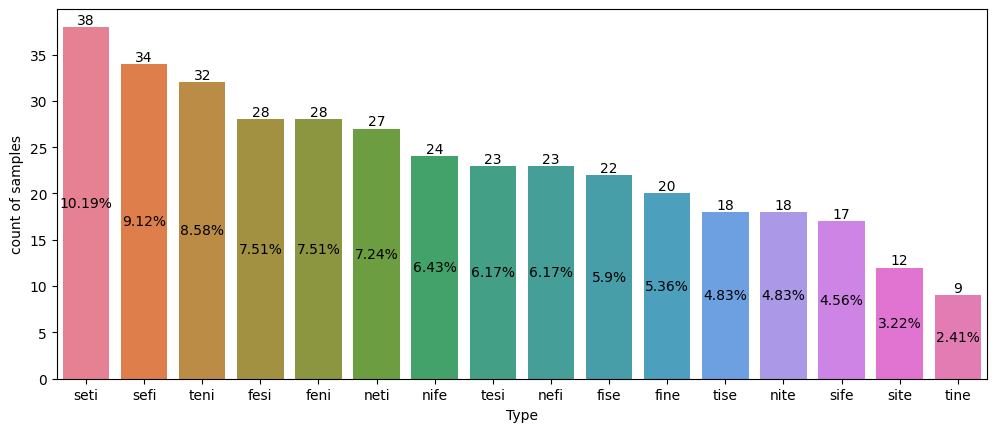

In [60]:
Type_counts.reset_index(inplace=True)
plt.figure(figsize=(12, 4.8))
ax = sns.barplot(Type_counts, x='Type', y='count', hue='Type')
for i in range(len(Type_counts)):
    ax.bar_label(ax.containers[i], fontsize=10)
    ax.bar_label(ax.containers[i], fontsize=10, label_type='center', labels=[str(Type_counts.loc[i, 'percent'])+'%'])
plt.xlabel("Type")
plt.ylabel("count of samples");

For the most part, this lapis variant seems to have a smoother distributions of types (particularly due to having fewer SeTi), but towards the lower end we did lose a lot of SiTe and TiNe who have now become exceptionally rare

### Lead Energetic <a id="Lead"></a>

In [61]:
LE_counts = lapis_df['Lead Energetic'].value_counts().to_frame()
LE_counts['percent'] = (100 * LE_counts['count'] / len(lapis_df)).round(2)
LE_counts

,count,percent
Lead Energetic,,
Pe,122,32.71
Je,111,29.76
Pi,71,19.03
Ji,69,18.50


The distribution is somewhat evened out in terms of Pe and Je compared to the full data, but mostly it's very similar (so I'm surprised it was even flagged as different as it is, especially since the order is unchanged

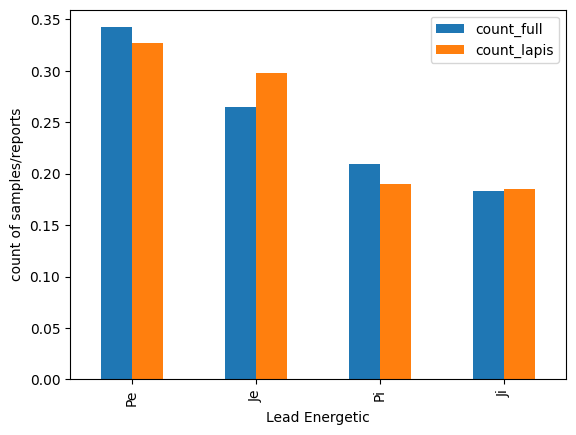

In [64]:
le_join = (all_df['Lead Energetic'].value_counts()/len(all_df)).to_frame().join((lapis_df['Lead Energetic'].value_counts()/len(lapis_df)).to_frame(), lsuffix='_full', rsuffix='_lapis')
le_join.plot(use_index=True, y=['count_full', 'count_lapis'], kind='bar')
plt.ylabel("count of samples/reports");

### Quadra <a id="Quadra"></a>

In [65]:
Quadra_counts = lapis_df['Quadra'].value_counts().to_frame()
Quadra_counts['percent'] = (100 * Quadra_counts['count'] / len(lapis_df)).round(2)
Quadra_counts

,count,percent
Quadra,,
Beta,108,28.95
Gamma,106,28.42
Alpha,81,21.72
Delta,78,20.91


There is a much closer balance between Beta and Gamma than last time (partly because we lost so many SeTi no doubt). There is also more balance between Grounded and Suspended because we lost a larger number of grounded samples in the cut

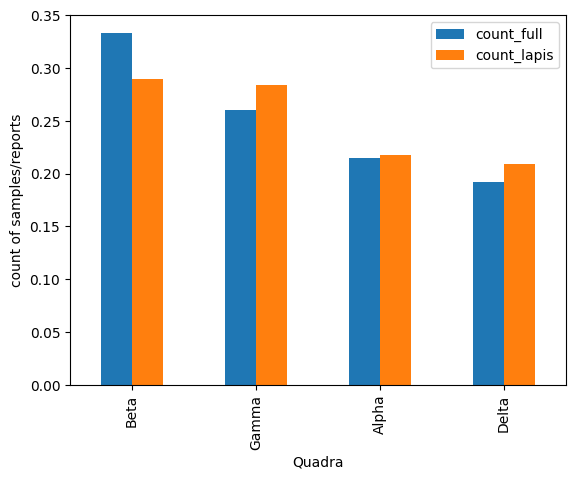

In [66]:
quadra_join = (all_df['Quadra'].value_counts()/len(all_df)).to_frame().join((lapis_df['Quadra'].value_counts()/len(lapis_df)).to_frame(), lsuffix='_full', rsuffix='_lapis')
quadra_join.plot(use_index=True, y=['count_full', 'count_lapis'], kind='bar')
plt.ylabel("count of samples/reports");

For the features that aren't part of some larger group, those 3 are the only 3 that are clearly statistically significant in their difference from the full data after the cut. Development and Emotions are close enough that I can at least take a quick look at them though

### Development <a id="Development"></a>

In [67]:
Dev_counts = lapis_df['Development'].value_counts().to_frame()
Dev_counts['percent'] = (100 * Dev_counts['count'] / len(lapis_df['Development'])).round(2)
Dev_counts

,count,percent
Development,,
i---,96,25.74
i-i-,65,17.43
ii--,54,14.48
i--i,41,10.99
ii-i,32,8.58
iii-,32,8.58
i-ii,32,8.58
iiii,21,5.63


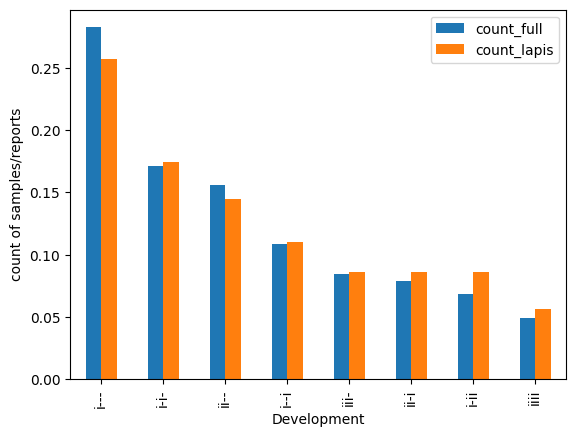

In [68]:
dev_join = (all_df['Development'].value_counts()/len(all_df)).to_frame().join((lapis_df['Development'].value_counts()/len(lapis_df)).to_frame(), lsuffix='_full', rsuffix='_lapis')
dev_join.plot(use_index=True, y=['count_full', 'count_lapis'], kind='bar')
plt.ylabel("count of samples/reports");

I can see why this distribution was not considered different in a statistically significant way, because the only notable difference I see is a loss of more i--- devs for the most part. Considering emotions has an even lower degree of difference from the full data than this, I won't bother examining it

For the grouped up signals, the only one's consistantly reaching different levels of statistical significance in their changes are the 4 sets of quadra signals. I won't examine the other groups of signals for now but if they get notably different results in our other investigations, we can always investigate more at that point

### Candid Signals <a id="Candid"></a>

In [69]:
lapis_df.loc[:,'CA1 Taut Nasolabial Area':'CA9 Grasping Hands'].describe()

,CA1 Taut Nasolabial Area,CA2 Vertical Snarling Smiles,CA3 Four Point Pulling,CA4 Wobbling Lips,CA5 Asymmetrical Smirks,CA6 Sassy Movements,CA7 Plateau Velocity,CA8 Nasal Breathy Voice,CA9 Grasping Hands
count,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,2.895442,2.522788,3.040214,2.817694,1.664879,2.294906,2.552279,1.729223,1.187668
std,2.105371,2.550067,2.347726,2.080118,1.912825,2.229784,2.439720,2.426141,1.811599
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000
75%,4.000000,4.000000,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000,2.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


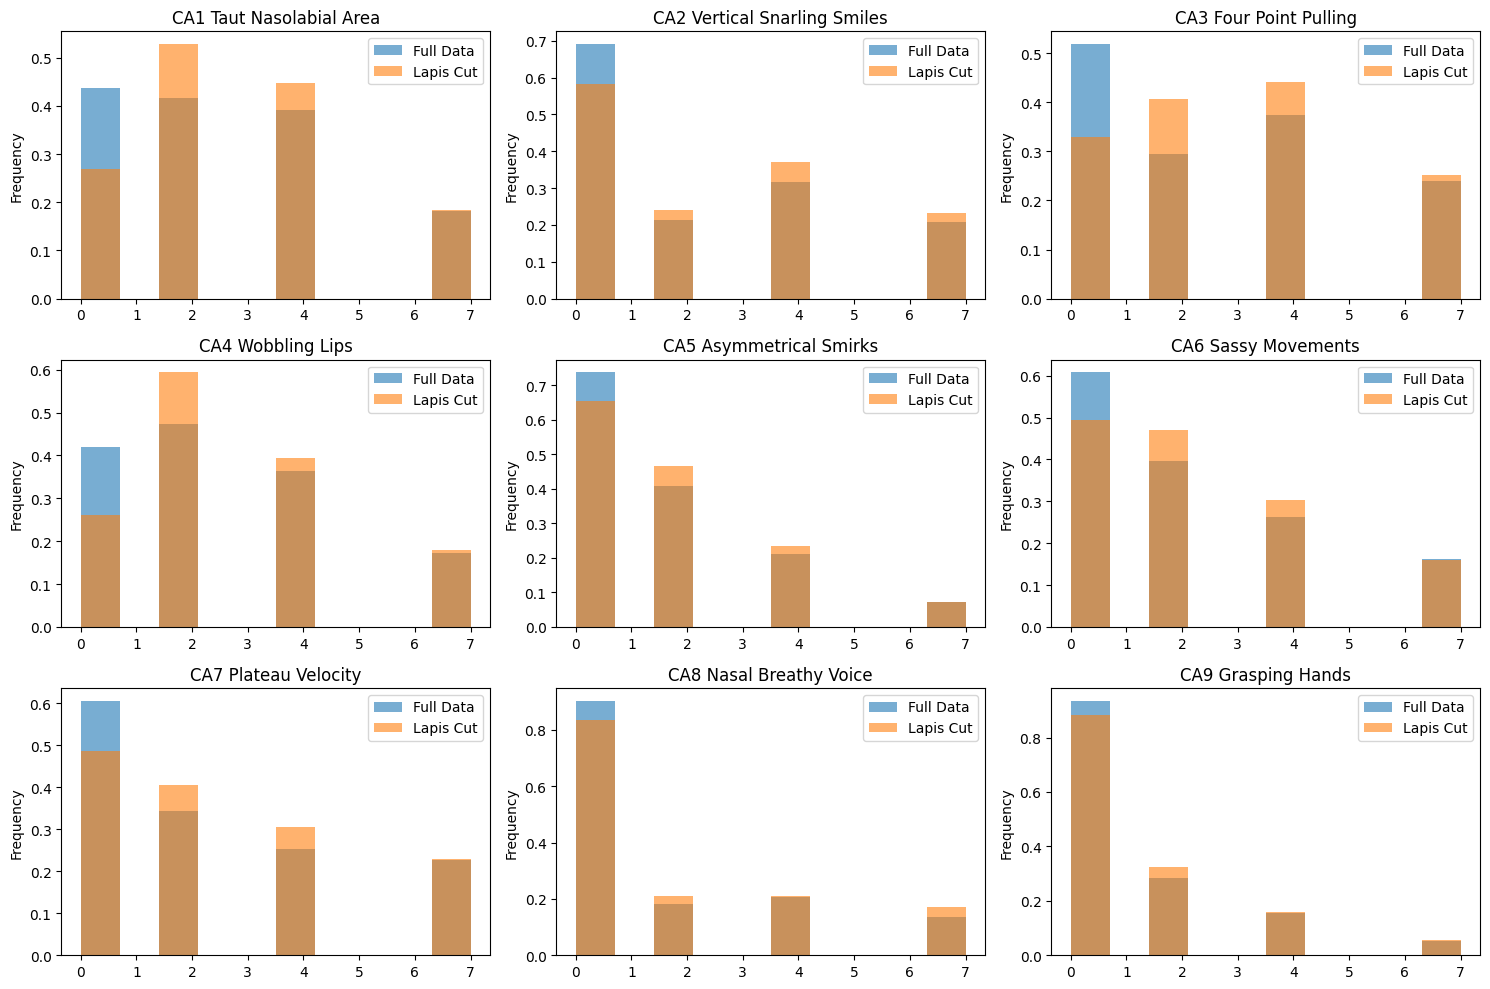

In [71]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(all_df.loc[:,'CA1 Taut Nasolabial Area':'CA9 Grasping Hands'].columns):
    ax = axes[i]
    all_df[column].plot(kind='hist', density=True, alpha=0.6, label='Full Data', ax=ax)
    lapis_df[column].plot(kind='hist', density=True, alpha=0.6, label='Lapis Cut', ax=ax)
    ax.set_title(column)
    ax.legend()

plt.tight_layout()
plt.show()

One major theme is that we are losing entirely in proportion from the 0 values (because we cut a lot of samples with 0 Candid score that would have had 0 on all of these), and mostly what grows are the low (2 point) signals with a little bit of growth from the medium and very little growth in proportion of 7 point high signals. I imagine that we will see this pattern repeat

### Measured Signals <a id="Measured"></a>

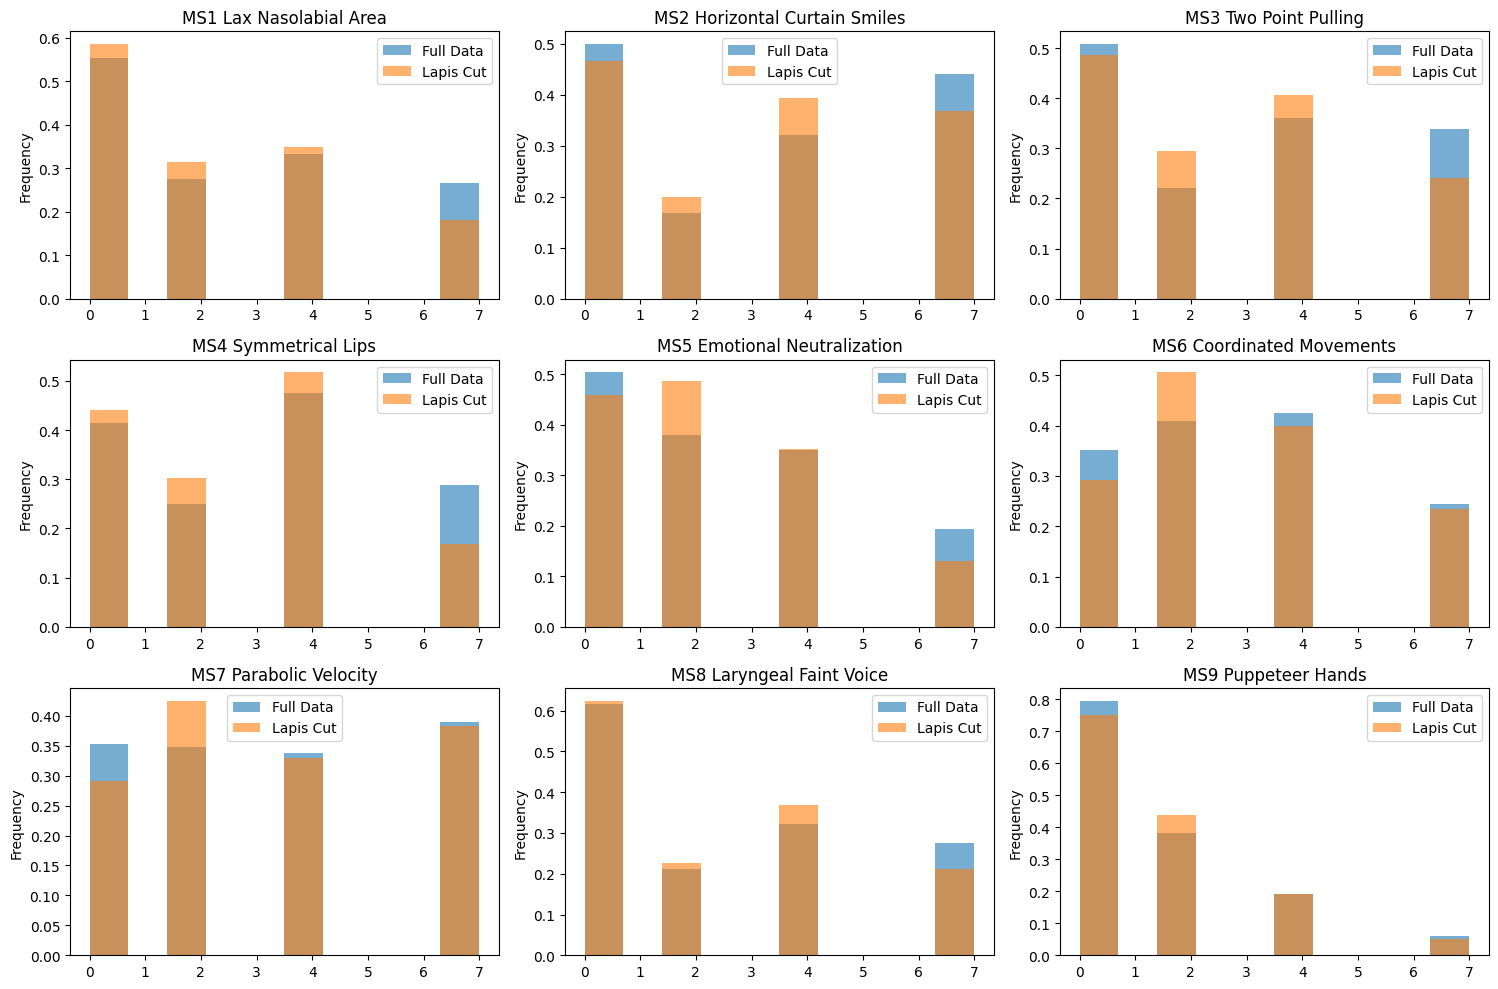

In [72]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(all_df.loc[:,'MS1 Lax Nasolabial Area':'MS9 Puppeteer Hands'].columns):
    ax = axes[i]
    all_df[column].plot(kind='hist', density=True, alpha=0.6, label='Full Data', ax=ax)
    lapis_df[column].plot(kind='hist', density=True, alpha=0.6, label='Lapis Cut', ax=ax)
    ax.set_title(column)
    ax.legend()

plt.tight_layout()
plt.show()

I imagined incorrect and trend absolutely does not continue! Although some signals (Coordinated Movements and Parabolic Velocity) lose primarily a proportion of 0 values, more often signal lose of a proportion of 7 valued (high) signals! This includes Lax Nasolabial Area, Horizontal Curtain Smiles, Two Point Pulling, Symmetrical Lips, Neutralization, and Laryngeal Faint Voice. This might happen because Measured signals tend to have greater variability, so when we got rid of the samples that were purely Measured, their Measured Signals have a higher number of 7 scores. We still got rid of a fair number of samples with 0 Measured signals so it's somewhat two-sided in this case.

### Grounded Signals <a id="Grounded"></a>

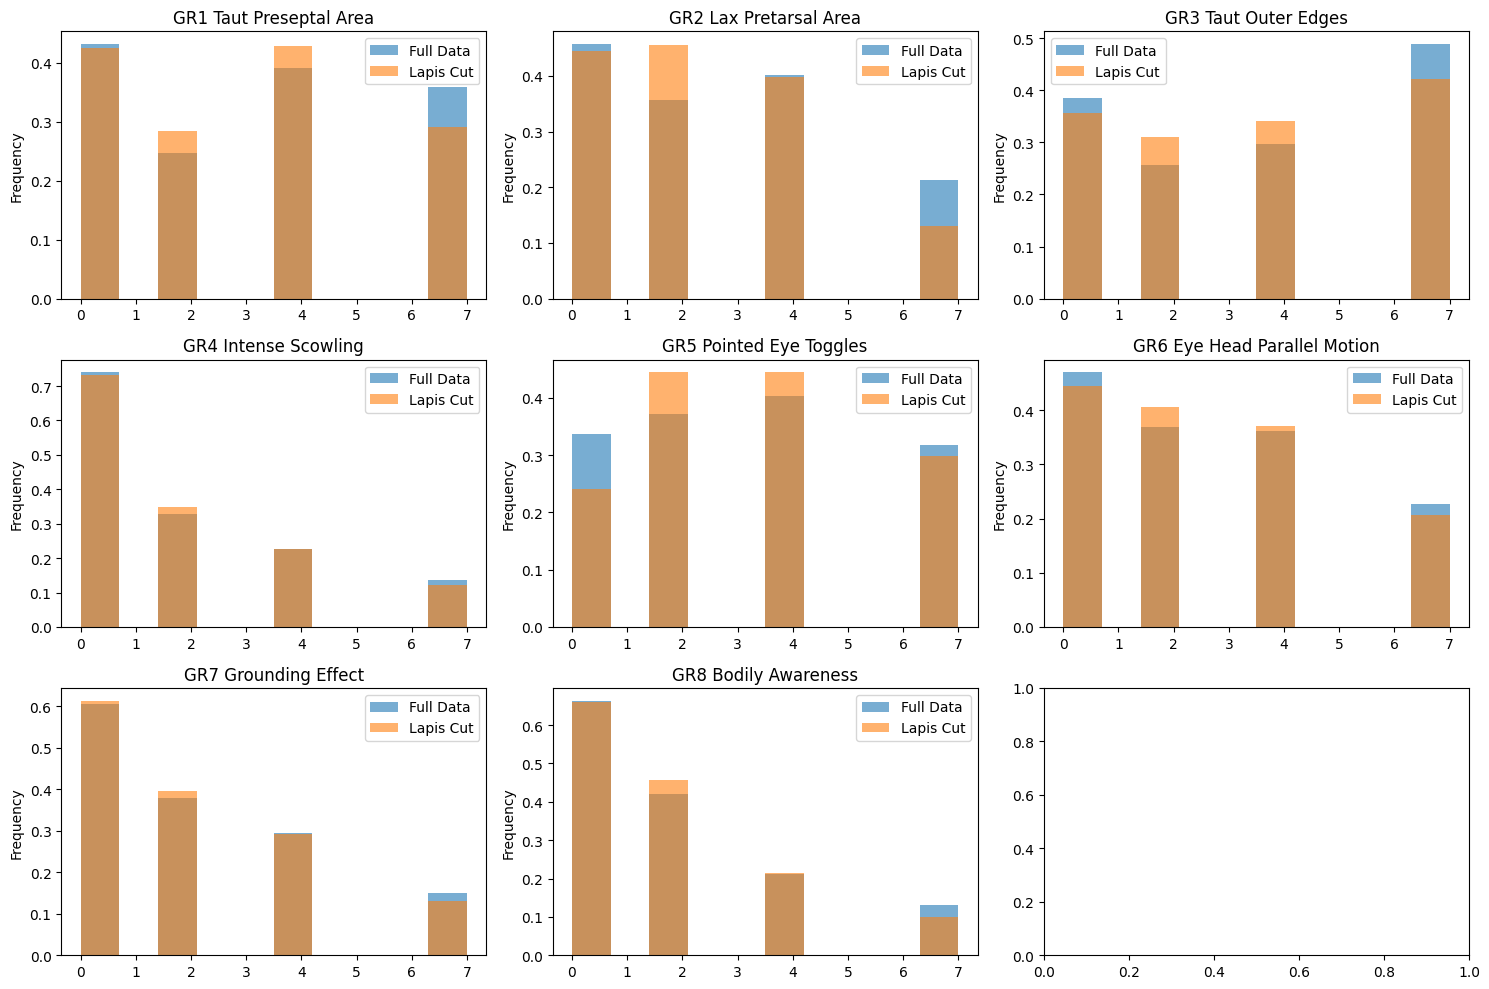

In [73]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(all_df.loc[:,'GR1 Taut Preseptal Area':'GR8 Bodily Awareness'].columns):
    ax = axes[i]
    all_df[column].plot(kind='hist', density=True, alpha=0.6, label='Full Data', ax=ax)
    lapis_df[column].plot(kind='hist', density=True, alpha=0.6, label='Lapis Cut', ax=ax)
    ax.set_title(column)
    ax.legend()

plt.tight_layout()
plt.show()

This is similar in result to Measured and not Candid, and it seems to be for the same reason; that Measured and Grounded are the more plentiful samples (both in general and at the extreme edges of "purity" that we graphed at the beginning of this notebook). Because we lost more Measured and Grounded samples, we lost more samples that are "high" in those signals, and thus we lose most of all towards the higher end of markings on those signals.

I would predict that Suspended signals will show more similar results to Candid signals

### Suspended Signals <a id="Suspended"></a>

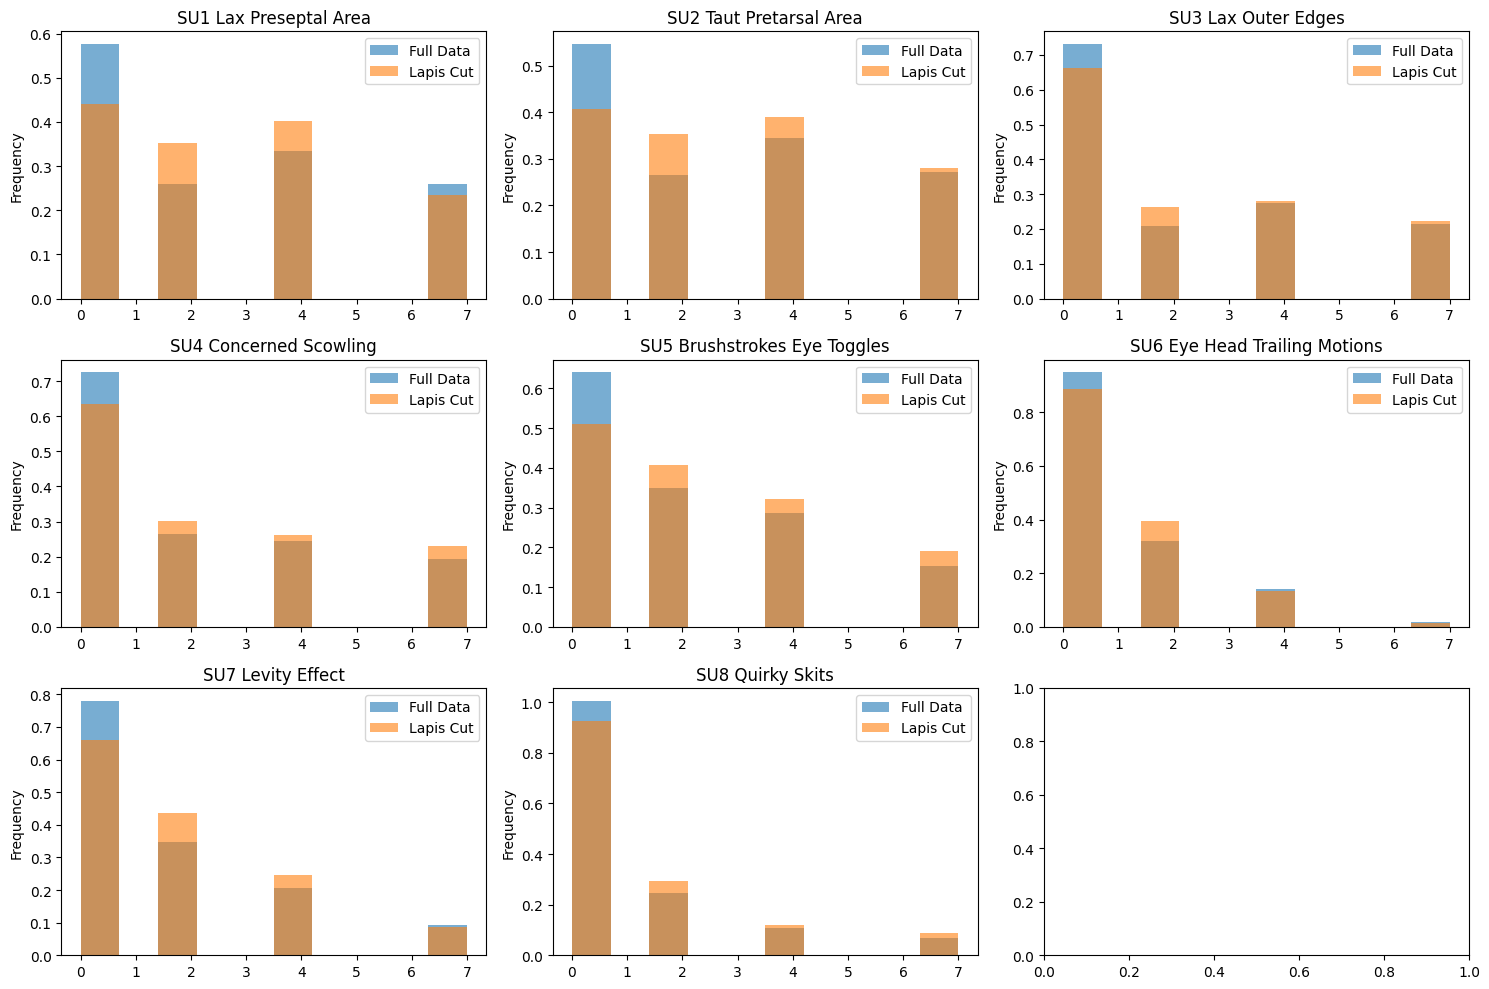

In [74]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(all_df.loc[:,'SU1 Lax Preseptal Area':'SU8 Quirky Skits'].columns):
    ax = axes[i]
    all_df[column].plot(kind='hist', density=True, alpha=0.6, label='Full Data', ax=ax)
    lapis_df[column].plot(kind='hist', density=True, alpha=0.6, label='Lapis Cut', ax=ax)
    ax.set_title(column)
    ax.legend()

plt.tight_layout()
plt.show()

This time my prediction was correct, and Suspended signals lose more towards the lower end, because they are less plentiful (both in general and towards the edges of extreme purity) as with Candid signals

There is one more interesting peculiarity I'd like to examine for now: the Emotionally Guarded signals in the lapis version have almost no difference in distribution from the full data (thus very high p-values), but the Emotionally Unguarded signals tend to have rather low p-values as well (and are the last group of signals that has this feature). This is peculiar because theoretically they should have nothing to do with the samples that we cut due to the lack of any signal mixing on the quadra axes, yet in practice Unguarded signals seem to have been impacted to a statistically significant degree

### Unguarded Signals: An Unusual Change <a id="Unguarded"></a>

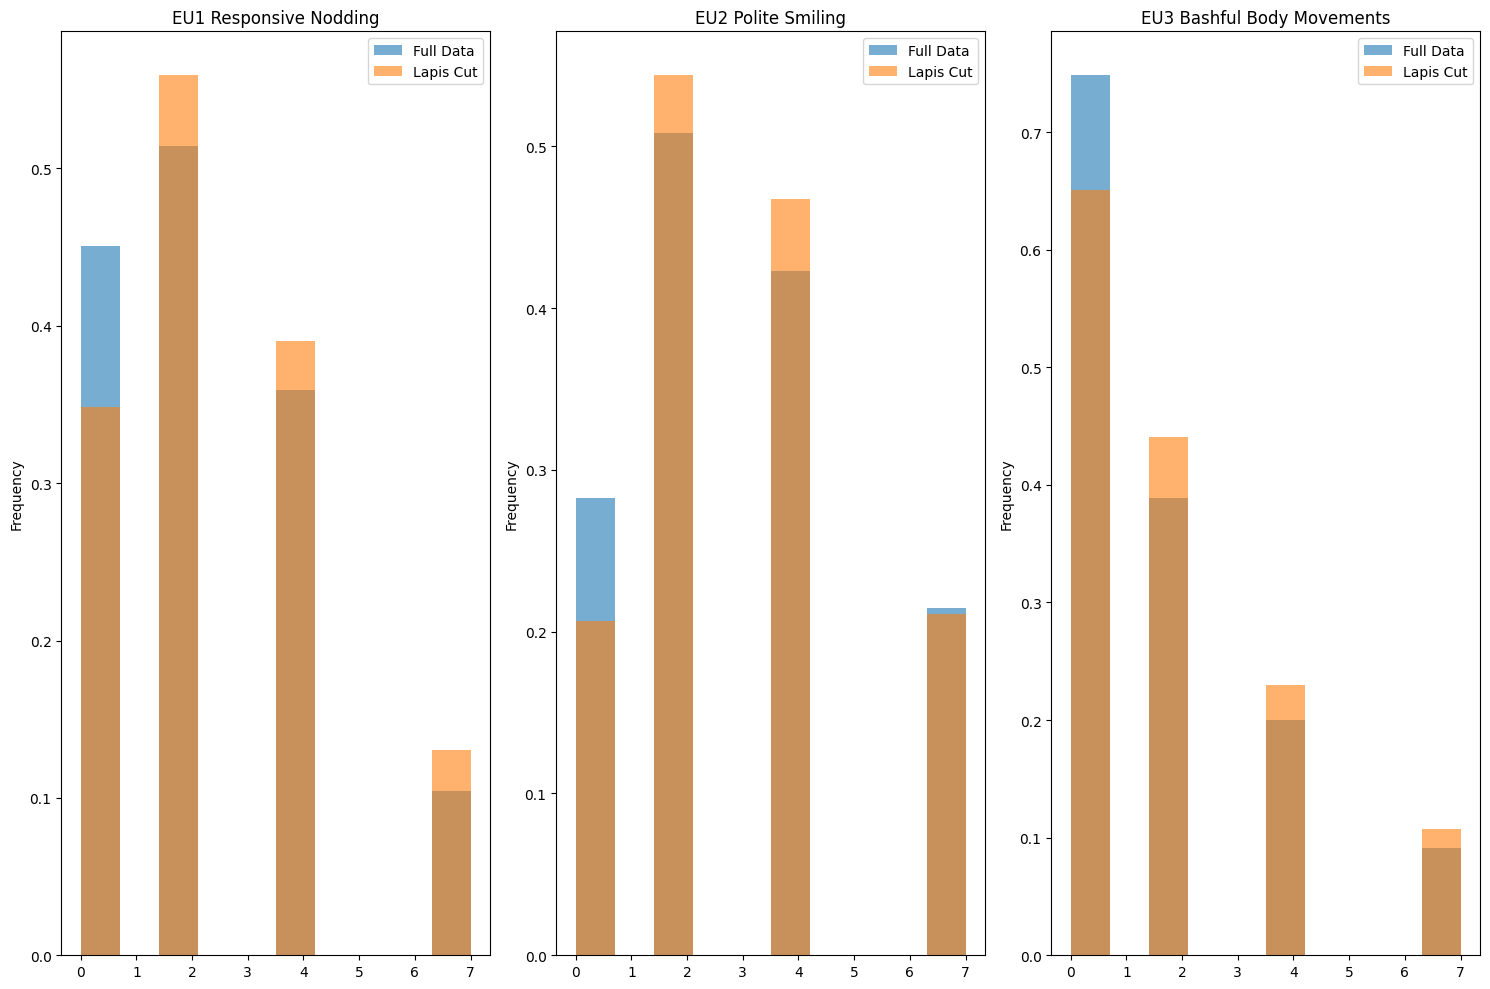

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(all_df.loc[:,'EU1 Responsive Nodding':'EU3 Bashful Body Movements'].columns):
    ax = axes[i]
    all_df[column].plot(kind='hist', density=True, alpha=0.6, label='Full Data', ax=ax)
    lapis_df[column].plot(kind='hist', density=True, alpha=0.6, label='Lapis Cut', ax=ax)
    ax.set_title(column)
    ax.legend()

plt.tight_layout()
plt.show()

For unguarded samples, we are losing more 0 values (similar to Candid and Suspended signals). But in this case it is not for the same reason, since Unguarded samples are more common than Guarded samples (whereas Candid and Suspended samples are less common in the data). It is very curious that when cutting samples that have pure values on at least one of the quadra axes, we are losing even more of the guarded samples (thus guarded samples might be said to correlate with having more purity in their quadra signals).

Just to check whether this is really true, let's compare the distributions of emotional attitudes between the full data and the lapis version:

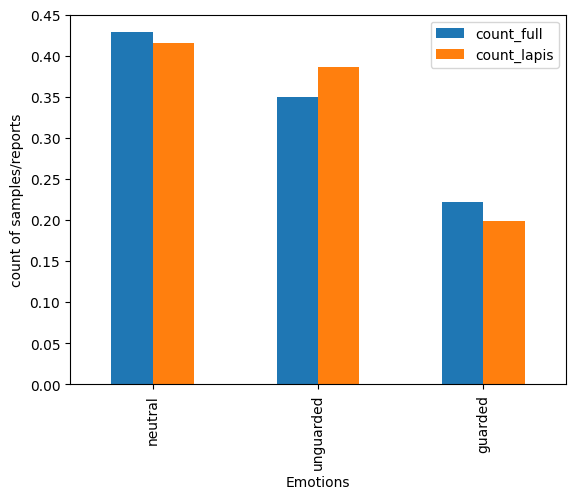

In [81]:
ea_join = (all_df['Emotions'].value_counts()/len(all_df)).to_frame().join((lapis_df['Emotions'].value_counts()/len(lapis_df)).to_frame(), lsuffix='_full', rsuffix='_lapis')
ea_join.plot(use_index=True, y=['count_full', 'count_lapis'], kind='bar')
plt.ylabel("count of samples/reports");

Indeed, that is what we observe: unguarded samples, which were already more common in the data, become even more proportionally common when removing samples that have any pure quadra axis. I'm not sure what to make of that now, but I'm curious if the effect will persist in the future of the data for this project.

## Saving the Data <a id="Saving"></a>

In [82]:
lapis_df.to_csv('../Data/posts_2024-12-29_LapisCut.csv')